In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import mmcv
import os
import torch
import tifffile
import scipy

In [4]:
root_path = "/media/electroscian/Datos/Cristian_WMH/Datos_ROBEX"
dirs = os.listdir(root_path + "/FLAIR")
np.random.shuffle(dirs)
l = len(dirs)
train_dirs = dirs[:int(l*0.8)]
val_dirs = dirs[int(l*0.8):]

In [49]:
def center_crop_batch(images, crop_size):
    cropped_images = []
    images = np.swapaxes(images, 2, 0)

    for image in images:
        height, width = image.shape[:2]
        crop_height, crop_width = crop_size
        
        # Calculate the starting point for the crop
        start_x = max(0, int((width - crop_width) / 2))
        start_y = max(0, int((height - crop_height) / 2))
        
        # Calculate the ending point for the crop
        end_x = min(width, start_x + crop_width)
        end_y = min(height, start_y + crop_height)
        
        # Calculate the border dimensions
        border_left = int(max(0, crop_width/2 - width)/2)
        border_right = int(max(0, crop_width/2 - width)/2)
        border_top = int(max(0, crop_height - height)/2)
        border_bottom = int(max(0, crop_height - height)/2)
        
        # Perform the center crop
        cropped = image[start_y:end_y, start_x:end_x]
        
        # Expand the border if necessary
        cropped = cv2.copyMakeBorder(cropped, border_top, border_bottom, border_left, border_right, cv2.BORDER_REPLICATE)
        
        cropped_images.append(cropped)
        
    return np.array(cropped_images)

def preprocessing_mri(images, label):
  flair, t1 = images

  #Crop images
  c_flair = center_crop_batch(flair, (224,224))
  c_t1 = center_crop_batch(t1, (224,224))
  c_label = center_crop_batch(label, (224,224))

  #Erase no info images
  sum_nozero = np.where(np.sum(c_flair, axis=(1, 2)) > 0)
  new_flair = c_flair[np.min(sum_nozero):np.max(sum_nozero)+1,:,:]
  new_flair = new_flair.astype(np.float64)
  new_flair = np.expand_dims(new_flair, 3)

  sum_nozero = np.where(np.sum(c_t1, axis=(1, 2)) > 0)
  new_t1 = c_t1[np.min(sum_nozero):np.max(sum_nozero)+1,:,:]
  new_t1 = new_t1.astype(np.float64)
  new_t1 = np.expand_dims(new_t1, 3)

  new_label = c_label[np.min(sum_nozero):np.max(sum_nozero)+1,:,:]
  new_label[new_label != 1] = 0
  new_label = new_label.astype(np.uint8)

  new2_flair = z_score(new_flair)
  new2_t1 = z_score(new_t1)


  f_image = np.concatenate((new2_flair, new2_t1), 3)
  new_img = t1t2(new2_flair, new2_t1,True)
  new_img = np.where(new_t1 == 0, 0, new_img)
  #new_img = np.zeros(new_flair.shape, dtype=np.float64)
  f_image = np.concatenate((f_image, new_img), 3)
  
  
#   f_image = np.concatenate((new_flair, new_flair), 3)
#   #new_img = t1t2(new_flair,new_t1,True)
#   new_img = np.zeros(new_flair.shape, dtype=np.float64)
#   f_image = np.concatenate((f_image, new_flair), 3)


  return f_image, new_label

def t1t2(a,b, truncate=False):
    div = np.divide(b,a, where=b!=0)
    if truncate:
        percentile_1 = np.percentile(div, 2)
        percentile_99 = np.percentile(div, 98)
        div = np.clip(div,percentile_1,percentile_99)
        normalized_data = (div - percentile_1) / (percentile_99 - percentile_1)
        return normalized_data
    return div

def z_score(data, lth = 0.02, uth = 0.98):
    
    temp = np.sort(data[data>0])
    lth_num = int(temp.shape[0]*0.02)
    uth_num = int(temp.shape[0]*0.98)
    data_mean = np.mean(temp[lth_num:uth_num])
    data_std = np.std(temp[lth_num:uth_num])
    data = (data - data_mean)/data_std
    
    return data

def minmax(image_data):
    percentile_1 = np.min(image_data)
    percentile_99 = np.max(image_data)
    normalized_data = (image_data - percentile_1) / (percentile_99 - percentile_1)
    return normalized_data

In [ ]:
def multi_label(label):
    

In [16]:
train_dims = []
val_dims = []
index = 0
for file in train_dirs:
    #Obtain data
    data_flair = nib.load(root_path + f"/FLAIR/{file}" ).get_fdata()
    data_t1 = nib.load(root_path + f"/T1/{file}" ).get_fdata()
    data_label = nib.load(root_path + f"/WMH/{file}" ).get_fdata()
    
    #Preprocessing
    data = preprocessing_mri((data_flair, data_t1), data_label)
    train_dims.append(data[0].shape[0])
    
    for i in range(data[0].shape[0]):
        l_index = len(str(index))
        num = "0"*(6-l_index) + str(index)
        
        #Save images
        slice_data = data[0][i,:, :, :]
        tifffile.imwrite('data/WMH3/imgs/train/{}.tiff'.format(num), slice_data)
        
        #Save labels
        slice_data = data[1][i,:, :]
        #Dilatation
        slice_data = scipy.ndimage.binary_dilation(slice_data).astype(np.int8)
        mmcv.imwrite(slice_data, 'data/WMH3/label/train/{}.png'.format(num))
        
        index +=1
        
        print(index, end="\r")
        
for file in val_dirs:
    #Obtain data
    data_flair = nib.load(root_path + f"/FLAIR/{file}" ).get_fdata()
    data_t1 = nib.load(root_path + f"/T1/{file}" ).get_fdata()
    data_label = nib.load(root_path + f"/WMH/{file}" ).get_fdata()
    
    #Preprocessing
    data = preprocessing_mri((data_flair, data_t1), data_label)
    val_dims.append(data[0].shape[0])
    
    for i in range(data[0].shape[0]):
        l_index = len(str(index))
        num = "0"*(6-l_index) + str(index)
        
        #Save images
        slice_data = data[0][i,:, :, :]
        tifffile.imwrite('data/WMH3/imgs/val/{}.tiff'.format(num), slice_data)
        
        #Save labels
        slice_data = data[1][i,:, :]
        #Dilatation
        mmcv.imwrite(slice_data, 'data/WMH3/label/val/{}.png'.format(num))
        
        index +=1
        print(index, end="\r")

        
        

In [6]:
test_flair = root_path + "/FLAIR/008.nii.gz"
test_t1 = root_path + "/T1/008.nii.gz"
test_label = root_path + "/WMH/008.nii.gz"

In [7]:
data_flair = nib.load(test_flair).get_fdata()
data_t1 = nib.load(test_t1).get_fdata()
data_label = nib.load(test_label).get_fdata()

In [50]:
data_pre = preprocessing_mri((data_flair,data_t1), data_label)

In [219]:
data_pre[0].dtype

dtype('float64')

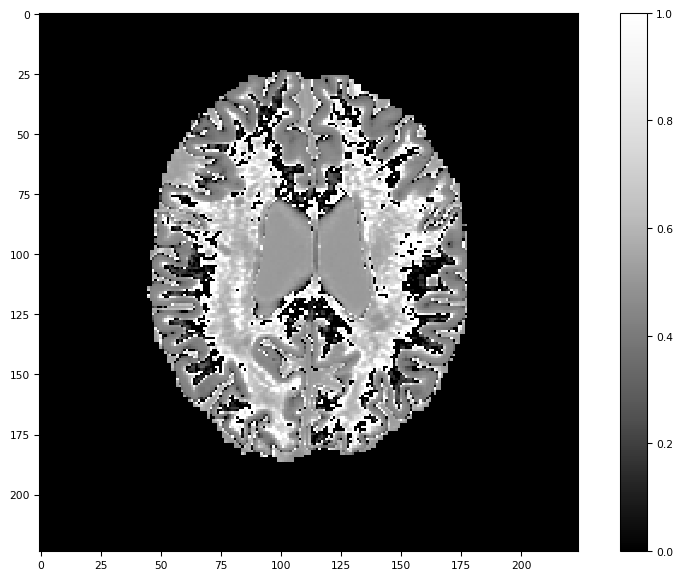

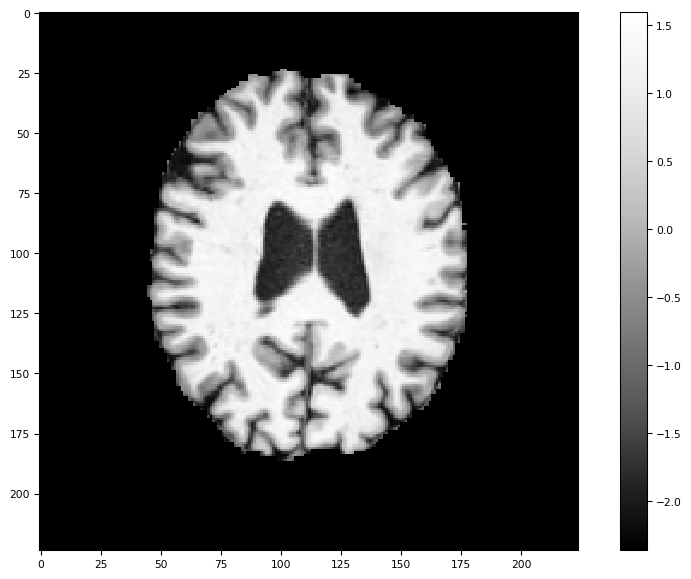

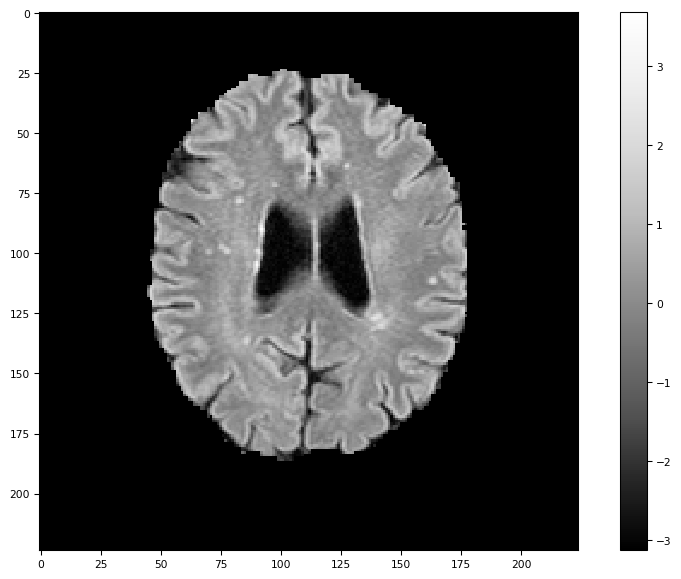

In [51]:
slide = 27
tifffile.imshow(data_pre[0][slide,:,:,2], cmap="Greys_r")
plt.show()
tifffile.imshow(data_pre[0][slide,:,:,1], cmap="Greys_r")
plt.show()
tifffile.imshow(data_pre[0][slide,:,:,0], cmap="Greys_r")
plt.show()

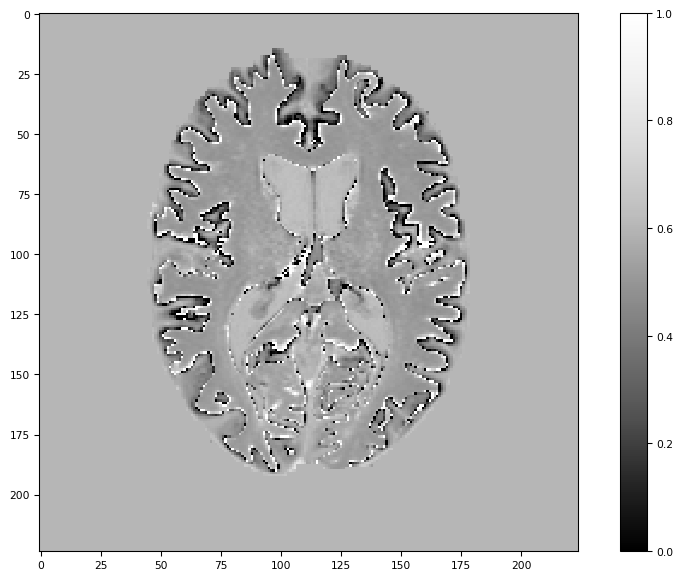

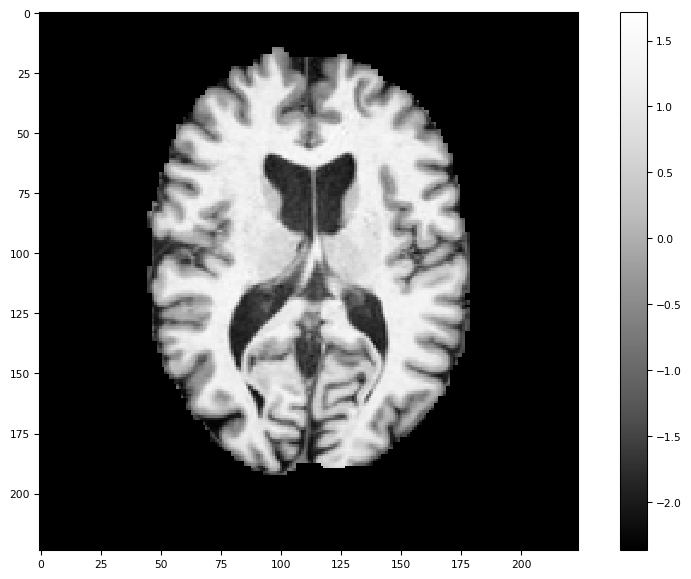

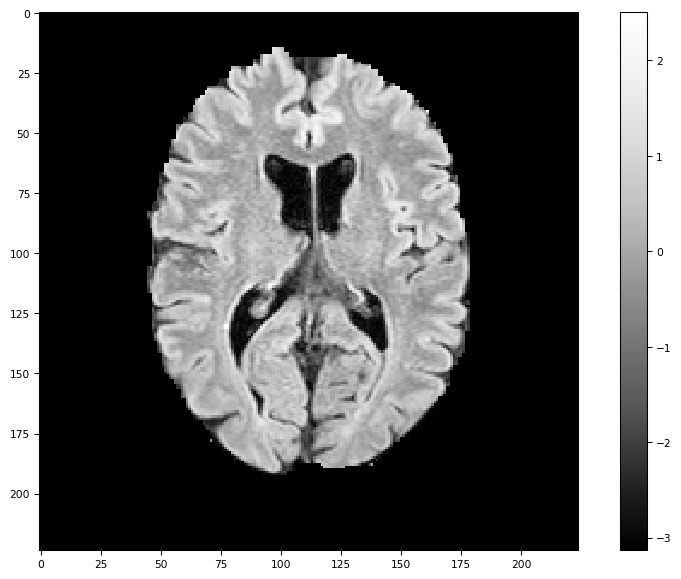

In [39]:
slide = 22
tifffile.imshow(data_pre[0][slide,:,:,2], cmap="Greys_r")
plt.show()
tifffile.imshow(data_pre[0][slide,:,:,1], cmap="Greys_r")
plt.show()
tifffile.imshow(data_pre[0][slide,:,:,0], cmap="Greys_r")
plt.show()

(<Figure size 988.8x604.8 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7ff3fbedfeb0>)

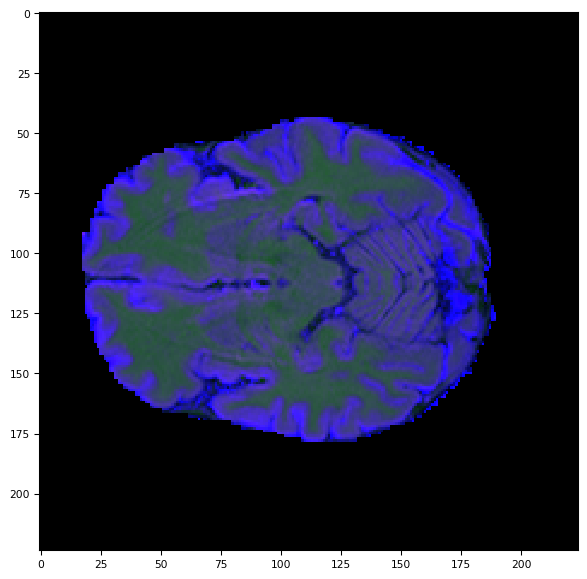

In [188]:
tifffile.imshow(data_pre[0][15,:,:,:])

In [13]:
data_test1[:,:,28]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
d_test = mmcv.imread("test.tiff", backend="tifffile")

In [9]:
img = nib.load(test_flair)
clipped_img = nib.Nifti1Image(data_test1, img.affine, img.header)

In [10]:
nib.save(clipped_img, '001_numpy_int16.nii')

In [175]:
data = preprocessing_mri((data_flair, data_t1), data_label)

In [177]:
np.max(data[1])

255

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f6a9f3b0280>)

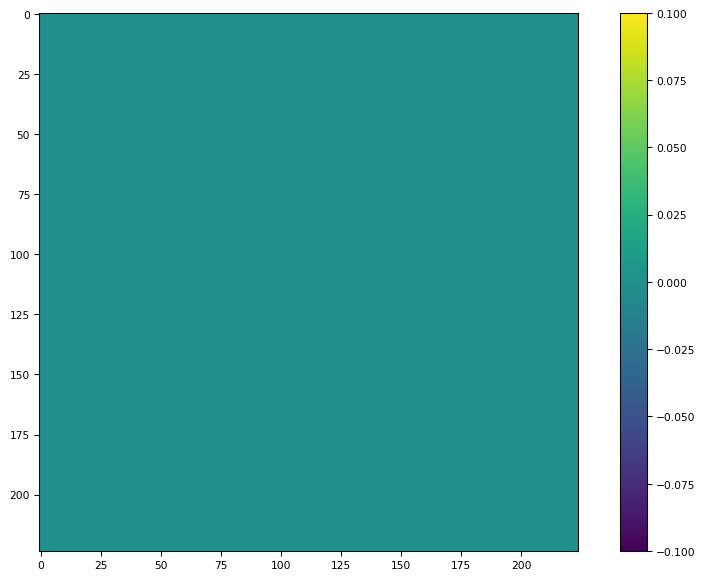

In [22]:
read_data = tifffile.imread("data/WMH2/imgs/val/005970.tiff")
tifffile.imshow(read_data[:,:,2])

Real Label


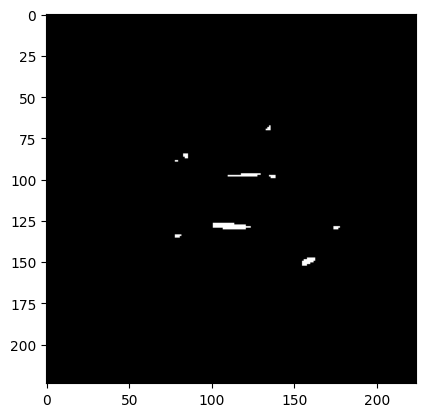

Prediction


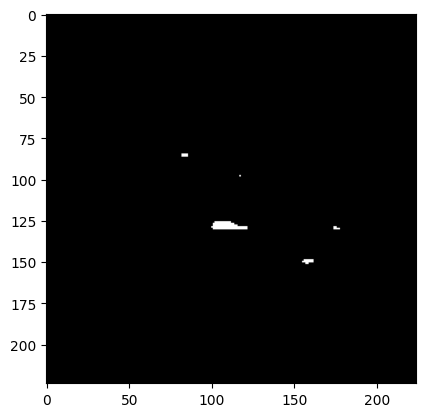

In [10]:
val = 6730

read_label = mmcv.imread(f"data/WMH_Multi/label1/val/00{val}.png")
print("Real Label")
plt.imshow(read_label*255)
plt.show()
read_label2 = mmcv.imread(f"/home/electroscian/Documents/mmsegmentation_whm/work_dirs/swin_segformer_whm_multi/outputs/00{val}.png")
print("Prediction")
plt.imshow(read_label2*255)
plt.show()

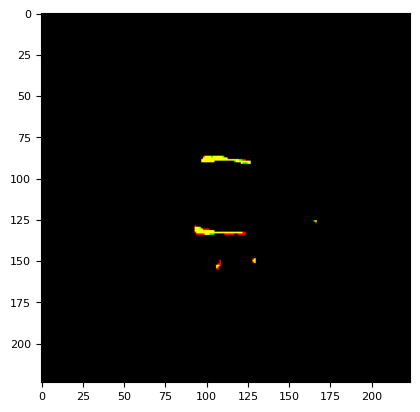

In [302]:
read_label[:,:,1] = read_label2[:,:,1]
read_label[:,:,2] = 0
plt.imshow(read_label*255)

Real Label


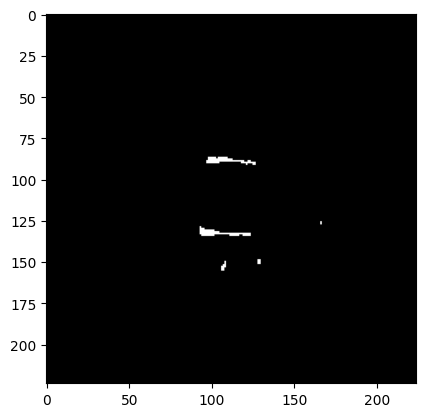

In [3]:
val = 6028

read_label = mmcv.imread(f"data/WMH2/label/val/00{val}.png")
print("Real Label")
plt.imshow(read_label*255)
plt.show()

Real Label


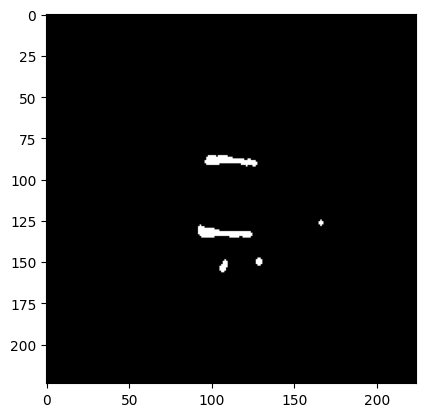

In [5]:
res = scipy.ndimage.binary_dilation(read_label)
print("Real Label")
plt.imshow(res*255)
plt.show()

In [13]:
res = res.astype(np.int8)

In [14]:
np.unique(res)

array([0, 1], dtype=int8)